# Student Data Visualization
In diesem Projekt wird mit anonymisierten und aus Datenschutzgründen verzerrten Studierendendaten gearbeitet.  Enthalten sind Informationen wie Studienstatus, absolvierte ECTS-Punkte pro Semester und viele andere Informationen, jeweils auf Semesterbasis.

Zweck ist, sinnvolle Darstellungen zu finden, die von wenig statistisch geschulten Personen gelesen und eventuell sogar interaktiv „verwendet“ werden können.

### Annahmen / Ziele

• Studierende mit internationalem Hintergrund studieren länger.<br>
• ECTS-Punkte nehmen über den Studienverlauf hinweg ab, um dann gegen Ende wieder anzusteigen.<br>
• Explorativ: Unterschiede zwischen Studiengängen, Identifikation von ECTS-schwachen und ECTS-intensiven Semestern bestimmter Studiengänge

### Prozessschritte

• <b>acquire & parse</b>: Erforderte nur Anonymisierung eines vorhandenen CSV mittels R scripts<br>
• <b>analyze/visualize</b>: seaborn, plotly, plotly express<br>
• <b>interact</b>: Dash und plotly express<br>
• <b>deployment</b>: ???

In [2]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from matplotlib import pyplot as plt

In [3]:
df_raw = pd.read_csv("student_dummy_data.csv", delimiter=";", encoding="latin-1", decimal=",")

In [47]:
# [print(element) for element in df_raw.columns]
df_raw.columns

Index(['MATRIKELNUMMER', 'STUDBEZ', 'ZULAC', 'SEMESTER_ID', 'STUDIENJAHR',
       'ST_SEM_NR', 'StudienStatusCode', 'StatusgruppeS', 'StatusgruppeSem1',
       'STUDBEZ_kompakt', 'Studart', 'Studgruppe', 'FAMILIENNAME', 'VORNAME',
       'GESCHLECHT', 'LAND_1', 'STUDDAUER', 'OUTGOINGSEM', 'Beginndat_Min',
       'Endedat_Max', 'besuchtesSemester', 'Alter', 'Ueberlaenge',
       'StatusgruppeR', 'ECTS_Sem', 'SWS_Sem', 'ECTS_Sj', 'SWS_Sj', 'prfakt',
       'IncomingsemUHSBV'],
      dtype='object')

In [96]:
df = df_raw.copy()
df["Land"] = "International"
# Variable that splits students in two groups based on Austrian citizenship
df.loc[df['LAND_1'] == "Österreich", 'Land'] = "Österreich"

array(['Studienabschluss', 'Studienunterbrechung_Ende',
       'Studienfortsetzung', 'Studienunterbrechung_Beginn',
       'Studienbeginn', 'Studienabbruch', nan, 'Studienwechsel+',
       'Beurlaubung', 'Studienwechsel-'], dtype=object)

In [78]:
df_by_semester_and_study_grps = df.groupby(["besuchtesSemester", "STUDBEZ_kompakt"])
df_by_semester_and_study_agg = df_by_semester_and_study_grps["ECTS_Sem"].agg(["mean", "median"])
df_by_semester_and_study_agg = pd.DataFrame(df_by_semester_and_study_agg).reset_index()
df_by_semester_and_study_agg["mean"] = df_by_semester_and_study_agg["mean"].round(1)
df_by_semester_and_study_agg = df_by_semester_and_study_agg.astype({"besuchtesSemester": int})


### Studiendauer und Staatsangehörigkeit
Hier werden alle Beobachtungen (=Semester) mit dem Status "Studienabschluss" betrachtet.

Text(18, 2.1, 'nur 2 Fälle')

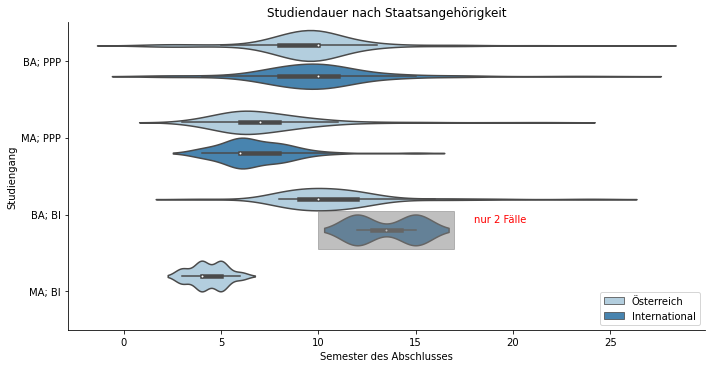

In [314]:
#from matplotlib import patches as mpatches
final_semesters = df.loc[df["StatusgruppeR"] == "Studienabschluss"]
#sns.barplot(data = final_semesters, x="Land", y="besuchtesSemester")

myplot = sns.catplot(data=final_semesters, 
            kind="violin", 
            y="STUDBEZ_kompakt",
            order=["BA; PPP", "MA; PPP", "BA; BI", "MA; BI"],
            x="besuchtesSemester",
            hue="Land", 
            cut=2, 
            bw=0.4, 
            legend=False,
            orient="h", 
            aspect=2, 
            palette="Blues")
plt.title("Studiendauer nach Staatsangehörigkeit")
plt.ylabel("Studiengang")
plt.xlabel("Semester des Abschlusses")
plt.legend(loc="lower right")

# getting figure object so gca can be applied
fig = myplot.figure

# this positioning is super clumsy but works
fig.gca().add_patch(Rectangle((10,1.95),7,0.5,fill=True, color='gray', alpha=0.5, zorder=100, figure=fig))
plt.text(18, 2.1, "nur 2 Fälle", fontdict={"color": "red"})


Der Violoinenplot weist darauf hin, dass die Studiendauer von internationalen Studierenden nur im Bachelor "Business Intelligence" deutlich länger ist. Allerdings sind hier nur 2 Fälle enthalten, was den Vergleich im Grunde unbrauchbar macht. 

<b>Die Annahme kann also nicht bestätigt werden.</b>

In [315]:
final_semesters.loc[final_semesters["STUDBEZ_kompakt"] == "BA; BI"]["Land"].value_counts()

Österreich       59
International     2
Name: Land, dtype: int64

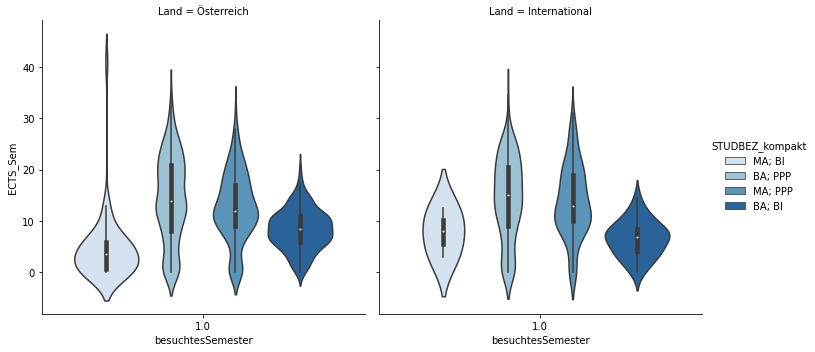

In [313]:
df_reduced = df.loc[df["besuchtesSemester"] == 1]
p = sns.catplot(data=df_reduced, 
kind="violin", 
x="besuchtesSemester", 
y="ECTS_Sem", 
hue="STUDBEZ_kompakt", 
col="Land",
palette="Blues")
#plt.ylim(0,60)
# would be useful to introduce trim, so that we "zoom in" more

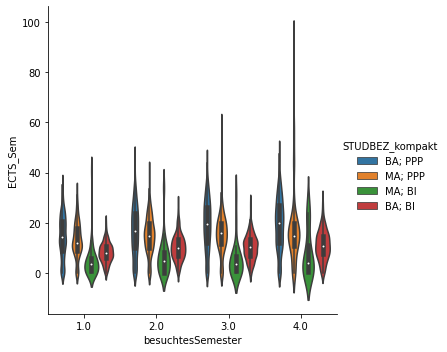

In [115]:
df_reduced = df.loc[df["besuchtesSemester"] <= 4]
sns.catplot(data=df_reduced, kind="violin", x="besuchtesSemester", y="ECTS_Sem", hue="STUDBEZ_kompakt")
#plt.ylim(0,60)

# would be useful to introduce trim, so that we "zoom in" more

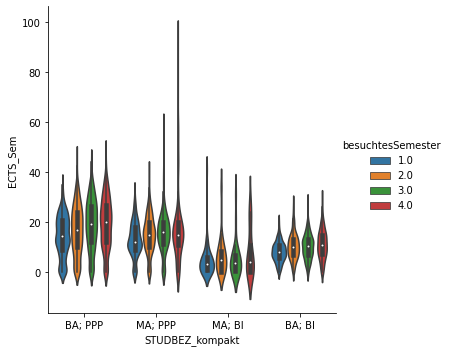

In [113]:
sns.catplot(data=df_reduced, kind="violin", x="STUDBEZ_kompakt", y="ECTS_Sem", hue="besuchtesSemester")

In [343]:
#df_raw.loc[df_raw["StatusgruppeR"] != "Beurlaubung"]

Text(0, 0.5, 'Semester')

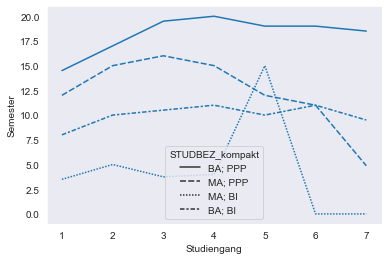

In [344]:
sns.lineplot(data=df_raw.loc[(df_raw["StatusgruppeR"] != "Beurlaubung") &
                            (df_raw["besuchtesSemester"] < 8)], 
            x="besuchtesSemester", 
            y="ECTS_Sem", 
            #hue="STUDBEZ_kompakt", 
            ci=None, 
            estimator="median", 
            style="STUDBEZ_kompakt")
plt.xlabel("Studiengang")
plt.ylabel("Semester")

([<matplotlib.axis.XTick at 0x2391b518e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

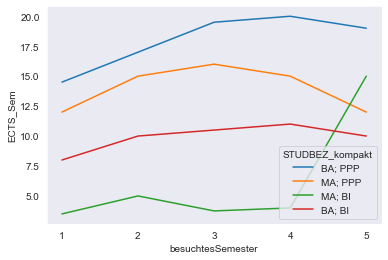

In [345]:
sns.set_style("dark")
sns.lineplot(data=df_raw.loc[df_raw.besuchtesSemester < 6], 
            x="besuchtesSemester", 
            y="ECTS_Sem", 
            hue="STUDBEZ_kompakt", 
            ci=None, 
            estimator="median")
plt.xticks(df_raw.loc[df_raw.besuchtesSemester < 6]["besuchtesSemester"].unique())

In [346]:
df_raw.loc[df_raw.besuchtesSemester < 9]

,MATRIKELNUMMER,STUDBEZ,ZULAC,SEMESTER_ID,STUDIENJAHR,ST_SEM_NR,StudienStatusCode,StatusgruppeS,StatusgruppeSem1,STUDBEZ_kompakt,...,besuchtesSemester,Alter,Ueberlaenge,StatusgruppeR,ECTS_Sem,SWS_Sem,ECTS_Sj,SWS_Sj,prfakt,IncomingsemUHSBV
0,801535,Bachelorstudium; Powerpoint,O,21S,2020/21,102,IX,Studienabschluss,,BA; PPP,...,6.0,34,-2.0,Studienabschluss,33.0,0.0,33.00,0.0,superprfakt,NaN
1,11932730,Bachelorstudium; Powerpoint,O,21S,2020/21,102,IX,Studienabschluss,,BA; PPP,...,3.0,28,-5.0,Studienabschluss,33.0,0.0,33.00,2.0,superprfakt,NaN
2,11935933,Bachelorstudium; Powerpoint,O,21S,2020/21,102,Bp,Studienunterbrechung_Ende,,BA; PPP,...,3.0,28,-5.0,Studienunterbrechung_Ende,32.0,0.0,32.00,0.0,superprfakt,NaN
3,1340104,Masterstudium; Powerpoint,O,21S,2020/21,102,IX,Studienabschluss,,MA; PPP,...,4.0,25,0.0,Studienabschluss,93.0,9.0,113.75,13.0,superprfakt,NaN
4,864344,Masterstudium; Powerpoint,O,19S,2018/19,98,IX,Studienabschluss,,MA; PPP,...,6.0,27,2.0,Studienabschluss,71.5,6.0,82.00,11.0,superprfakt,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15977,1184175,Masterstudium; Business Intelligence,O,20S,2019/20,100,I,Studienfortsetzung,,MA; BI,...,2.0,45,-2.0,Studienfortsetzung,0.0,0.0,0.00,0.0,zu wenig,NaN
15978,871547,Masterstudium; Business Intelligence,O,20S,2019/20,100,aB,Studienbeginn,,MA; BI,...,2.0,33,-2.0,Studienbeginn,0.0,0.0,0.00,0.0,keine Prüfungsaktivität,NaN
15979,1469750,Masterstudium; Business Intelligence,O,20S,2019/20,100,I,Studienfortsetzung,,MA; BI,...,2.0,26,-2.0,Studienfortsetzung,0.0,0.0,1.50,1.0,zu wenig,NaN
15983,1544673,Masterstudium; Business Intelligence,O,21S,2020/21,102,I,Studienfortsetzung,,MA; BI,...,1.0,39,-3.0,Studienfortsetzung,0.0,0.0,0.00,0.0,zu wenig,NaN


## Dash
https://www.youtube.com/watch?v=hSPmj7mK6ng&ab_channel=CharmingData


In [347]:
import pandas as pd
import numpy as np
import plotly.express as px
# import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output

In [348]:
fig = px.line(df_by_semester_and_study_agg, 
                x="besuchtesSemester", 
                y="mean", 
                color="STUDBEZ_kompakt", 
                title="<b>Durchschnittliche ECTS-Punkte nach besuchtem Semester im Studienverlauf</b>")
fig.update_xaxes(dtick=1)

In [393]:
max_semesters_to_display = 8
df_raw = pd.read_csv("student_dummy_data.csv", delimiter=";", encoding="latin-1", decimal=",")
df_reduced = df_raw.loc[df_raw["besuchtesSemester"] <= max_semesters_to_display]

In [394]:
df_reduced.STUDBEZ_kompakt.unique()

array(['BA; PPP', 'MA; PPP', 'MA; BI', 'BA; BI'], dtype=object)

In [395]:
px.bar(df_reduced, x="besuchtesSemester", y="ECTS_Sem")

In [396]:
df_by_semester_and_study_grps = df_reduced.groupby(["besuchtesSemester", "STUDBEZ_kompakt"])
df_by_semester_and_study_agg = df_by_semester_and_study_grps["ECTS_Sem"].agg(["mean", "median"])
df_by_semester_and_study_agg = pd.DataFrame(df_by_semester_and_study_agg).reset_index()


# -- replace 0 values with nan (which they are)
# df_by_semester_and_study_agg.loc[df_by_semester_and_study_agg["mean"]==0] = np.nan
# df_by_semester_and_study_agg.loc[df_by_semester_and_study_agg["median"]==0] = np.nan
# -- edit: this messed up the next step, so its commented out

df_by_semester_and_study_agg

,besuchtesSemester,STUDBEZ_kompakt,mean,median
0,1.0,BA; BI,8.198052,8.000
1,1.0,BA; PPP,14.431443,14.500
2,1.0,MA; BI,4.500000,3.500
3,1.0,MA; PPP,13.135281,12.000
4,2.0,BA; BI,10.350482,10.000
5,2.0,BA; PPP,16.717071,17.000
6,2.0,MA; BI,6.388889,5.000
7,2.0,MA; PPP,15.191143,15.000
8,3.0,BA; BI,10.301136,10.500
9,3.0,BA; PPP,19.117647,19.500


In [353]:
fig = px.line(df_by_semester_and_study_agg, 
                x="besuchtesSemester", 
                y="mean", 
                color="STUDBEZ_kompakt", 
                title="<b>Durchschnittliche ECTS-Punkte nach besuchtem Semester im Studienverlauf</b>")
fig.update_xaxes(dtick=1)

In [354]:
y_heights = df_by_semester_and_study_agg.loc[df_by_semester_and_study_agg["besuchtesSemester"]==max_semesters_to_display][["mean", "STUDBEZ_kompakt"]]
#y_heights = y_heights.sort_values(by="mean",ascending=False)
y_heights = y_heights.sort_values(by="mean", ascending=False)
y_heights_mean = list(y_heights["mean"])
y_heights_labs = list(y_heights["STUDBEZ_kompakt"])

ants = []

for i in range(0,4):
    ants.append(dict(xref='paper', 
                    x=1, 
                    y=round(y_heights_mean[i]),
                    xanchor='left', yanchor='middle',
                    text=y_heights_labs[i],
                    showarrow=False))

In [355]:
def create_lineplot_annotations_y(dataframe, 
                                    max_sem_in_plot,
                                    y_variable="mean", 
                                    group_variable="STUDBEZ_kompakt"):

    """
    This function creates y labels based on 'gorup_variable' for a line plot. 
    The labels are positioned at the height of the right-most y value.
    """
    y_heights = dataframe.loc[dataframe["besuchtesSemester"]==\
        max_sem_in_plot][[y_variable, group_variable]]
    y_heights = y_heights.sort_values(by="mean", ascending=False)
    y_heights_mean = list(y_heights[y_variable])
    y_heights_labs = list(y_heights[group_variable])

    ants = []

    for i in range(0,len(y_heights_labs)):
        ants.append(dict(xref='paper', 
                        x=1, 
                        y=round(y_heights_mean[i]),
                        xanchor='left', yanchor='middle',
                        text=y_heights_labs[i],
                        font={"family": "Arial", 
                        "size": 12},
                        showarrow=False))
    return(ants) # list of annotation dicts

In [365]:
# get the y label annotations
max_semesters_to_display = 8

df_by_semester_and_study_agg
dff = df_by_semester_and_study_agg.copy()
dff = dff[dff["besuchtesSemester"] <= max_semesters_to_display]
#dff = dff[dff["STUDBEZ_kompakt"] == "BA; PPP"]

antsis = create_lineplot_annotations_y(dataframe=dff, 
max_sem_in_plot = max_semesters_to_display, 
y_variable="mean", 
group_variable="STUDBEZ_kompakt")

# plot
fig = px.line(dff, 
                x="besuchtesSemester", 
                y="mean", 
                color="STUDBEZ_kompakt", 
                title="<b>Durchschnittliche ECTS-Punkte nach besuchtem Semester im Studienverlauf</b>", 
                labels=dict(besuchtesSemester="besuchtes Semester", 
                            mean = "ECTS-Punkte (Durchschnitt)"),
                markers=True)
# remove decimals from x axis
fig.update_xaxes(dtick=1)
# add anotations and hide legend
fig.update_layout(annotations=antsis, showlegend=False, 
                    yaxis_range=[0,25])

In [367]:
max_semesters_to_display = 4

app = Dash(__name__)

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1("Web Application Dashboards with Dash", style={'text-align': 'center'}),

    dcc.Dropdown(id="slct_study",
                 options=[
                     {"label": "BA; PPP", "value": "BA; PPP"},
                     {"label": "MA; PPP", "value": "MA; PPP"},
                     {"label": "BA; BI", "value": "BA; BI"},
                     {"label": "MA; BI", "value": "MA; BI"}],
                 multi=False,
                 value="BA; PPP",
                 style={'width': "40%"}
                 ),
    html.Br(),

    html.Div(id="output_container", children=[]),
    html.Br(),

    dcc.Graph(id="bof", figure={})

])


# ------------------------------------------------------------------------------
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id="output_container", component_property="children"),
     Output(component_id="bof", component_property="figure")],
    [Input(component_id="slct_study", component_property="value")]
    )
def update_graph(option_slctd):
    print(option_slctd)
    print(type(option_slctd))

    container = "The field of study chosen by user was: {}".format(option_slctd)

    dff = df_by_semester_and_study_agg.copy()
    dff = dff[dff["STUDBEZ_kompakt"] == option_slctd]
    dff = dff[dff["besuchtesSemester"] <= max_semesters_to_display]

    antsis = create_lineplot_annotations_y(dataframe=dff, 
    max_sem_in_plot = max_semesters_to_display, 
    y_variable="mean", 
    group_variable="STUDBEZ_kompakt")

    # plot
    fig = px.line(dff, 
                    x="besuchtesSemester", 
                    y="mean", 
                    color="STUDBEZ_kompakt", 
                    title="<b>Durchschnittliche ECTS-Punkte nach besuchtem Semester im Studienverlauf</b>", 
                    labels=dict(besuchtesSemester="besuchtes Semester", 
                                mean = "ECTS-Punkte (Durchschnitt)"),
                    markers=True)
    # remove decimals from x axis
    fig.update_xaxes(dtick=1)
    # add anotations and hide legend
    fig.update_layout(annotations=antsis, 
                    showlegend=False, 
                    yaxis_range=[0,25])
                
    return container, fig

In [368]:
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

In [371]:
import dash
import dash_core_components as dcc
import dash_table as dt
import dash_html_components as html

from dash.dependencies import Output, Input
from dash.exceptions import PreventUpdate

import plotly.graph_objs as go

sample_data = {
    'series': {
        'data': [
            {'title': 'Game of Thrones', 'score': 9.5},
            {'title': 'Stranger Things', 'score': 8.9},
            {'title': 'Vikings', 'score': 8.6}
        ],
        'style': {
            'backgroundColor': '#ff998a'
        }
    },
    'movies': {
        'data': [
            {'title': 'Rambo', 'score': 7.7},
            {'title': 'The Terminator', 'score': 8.0},
            {'title': 'Alien', 'score': 8.5}
        ],
        'style': {
            'backgroundColor': '#fff289'
        }
    }
}

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Multi output example'),
    dcc.Dropdown(id='data-dropdown', options=[
        {'label': 'Movies', 'value': 'movies'},
        {'label': 'Series', 'value': 'series'}
    ], value='movies'),
    html.Div([
        dcc.Graph(id='graph'),
        dt.DataTable(id='data-table', columns=[
            {'name': 'Title', 'id': 'title'},
            {'name': 'Score', 'id': 'score'}
        ])
    ])
], id='container')


@app.callback([
    Output('graph', 'figure'),
    Output('data-table', 'data'),
    Output('data-table', 'columns'),
    Output('container', 'style')
], [Input('data-dropdown', 'value')])
def multi_output(value):
    if value is None:
        raise PreventUpdate

    selected = sample_data[value]
    data = selected['data']
    columns = [
        {'name': k.capitalize(), 'id': k}
        for k in data[0].keys()
    ]
    figure = go.Figure(
        data=[
            go.Bar(x=[x['score']], text=x['title'], name=x['title'])
            for x in data
        ]
    )

    return figure, data, columns, selected['style']


if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

In [402]:
dff = df_by_semester_and_study_agg.copy()
a = dff.loc[dff["STUDBEZ_kompakt"] == "BA; PPP"]
b = dff.loc[dff["STUDBEZ_kompakt"] == "MA; PPP"]
dff = a.append(b)
dff

,besuchtesSemester,STUDBEZ_kompakt,mean,median
1,1.0,BA; PPP,14.431443,14.500
5,2.0,BA; PPP,16.717071,17.000
9,3.0,BA; PPP,19.117647,19.500
13,4.0,BA; PPP,19.458257,20.000
17,5.0,BA; PPP,18.350645,19.000
21,6.0,BA; PPP,18.277911,19.000
25,7.0,BA; PPP,17.635377,18.500
29,8.0,BA; PPP,17.349144,18.000
3,1.0,MA; PPP,13.135281,12.000
7,2.0,MA; PPP,15.191143,15.000


In [ ]:
import dash
import dash_core_components as dcc
import dash_table as dt
import dash_html_components as html

from dash.dependencies import Output, Input
from dash.exceptions import PreventUpdate

import plotly.graph_objs as go

sample_data = dff

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Multi output example'),
    dcc.Dropdown(id='data-dropdown', options=[
        {'label': 'BA', 'value': 'BA; PPP'},
        {'label': 'MA', 'value': 'MA; PPP'}
    ], value='BA; PPP'),
    html.Div([
        dcc.Graph(id='graph'),
        dt.DataTable(id='data-table', columns=[
            {'name': 'Study', 'id': 'title'},
            {'name': 'ECTS', 'id': 'score'}
        ])
    ])
], id='container')


@app.callback([
    Output('graph', 'figure'),
    Output('data-table', 'data'),
    Output('data-table', 'columns'),
    Output('container', 'style')
], [Input('data-dropdown', 'value')])
def multi_output(value):
    if value is None:
        raise PreventUpdate

    selected = sample_data[value]
    data = selected['data']
    columns = [
        {'name': k.capitalize(), 'id': k}
        for k in data[0].keys()
    ]
    figure = go.Figure(
        data=[
            go.Bar(x=[x['score']], text=x['title'], name=x['title'])
            for x in data
        ]
    )

    return figure, data, columns, selected['style']


if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

# SCRAP / ARCHIVE

In [ ]:
# BASIC VERSION of APP
app = Dash(__name__)

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1("Web Application Dashboards with Dash", style={'text-align': 'center'}),

    dcc.Dropdown(id="slct_study",
                 options=[
                     {"label": "BA; PPP", "value": "BA; PPP"},
                     {"label": "MA; PPP", "value": "MA; PPP"},
                     {"label": "BA; BI", "value": "BA; BI"},
                     {"label": "MA; BI", "value": "MA; BI"}],
                 multi=False,
                 value="BA; PPP",
                 style={'width': "40%"}
                 ),

    html.Div(id="output_container", children=[]),
    html.Br(),

    dcc.Graph(id="bof", figure={})

])


# ------------------------------------------------------------------------------
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id="output_container", component_property="children"),
     Output(component_id="bof", component_property="figure")],
    [Input(component_id="slct_study", component_property="value")]
    )
def update_graph(option_slctd):
    print(option_slctd)
    print(type(option_slctd))

    container = "The semester chosen by user was: {}".format(option_slctd)

    dff = df_by_semester_and_study_agg.copy()
    dff = dff[dff["STUDBEZ_kompakt"] == option_slctd]
    fig = px.line(dff, x="besuchtesSemester", y="mean")
    
    return container, fig